<a href="https://colab.research.google.com/github/JulianSchmidtke/CAPTUM/blob/main/AsuD_CAPTUM_v0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/JulianSchmidtke/CAPTUM.git

fatal: destination path 'CAPTUM' already exists and is not an empty directory.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

# Duplikate unter den Papern entfernen anhand der Hash-Werte

In [3]:
#Arbeitsverzeichnis auf das Ordnerverzeichnis ändern, in welchem die Daten liegen (txt-Format)

cwd = os.getcwd()
nwd = r'/content/CAPTUM/files'

os.chdir(nwd)

#Speichern der Dateinamen in einem Array
files = os.listdir()
df_files = pd.DataFrame(files, columns=['Filepath'])

In [4]:
# create checksum for each file to identify duplicates
# https://stackoverflow.com/questions/16874598/how-do-i-calculate-the-md5-checksum-of-a-file-in-python#16876405
import hashlib
def get_checksum(filepath: str) -> str:
    # Open,close, read file and calculate MD5 on its contents 
    with open(filepath, 'rb') as file_to_check:
        # read contents of the file
        data = file_to_check.read()    
        # pipe contents of the file through
        return hashlib.md5(data).hexdigest()
df_files['Checksum'] = df_files['Filepath'].apply(get_checksum)

In [5]:
#Den Inhalt der Paper einlesen und in einen Pandas-
df_files['Content'] = df_files['Filepath'].apply(lambda f: open(f, 'r', encoding = "ISO-8859-1").read())
df_files

,Filepath,Checksum,Content
0,CAPTUM_BAT_BHRA_Swerdt 2005.pdf_out_text.txt,cfc0bafeca8e44c8ae4b20db99d3f4d8,youpuap AB1a]|p poo\n\nS\nw\no\na\nw\n®\nY\na...
1,CAPTUM_BAT_Cyclosporine_Grattan 2000.pdf_out_t...,79e96f4baf3415f2597f79f00d86d3b1,British Journal of Dermatology 2000; 143: 365-...
2,CAPTUM_Severity_Duration_Arik yilmaz 2017.pdf_...,edb8e044a0018d41eeaad404dc4ee498,The persistence of chronic spontaneous urticar...
3,CAPTUM_Angioedema_Omalizumab_Maurer 2016 .pdf_...,cf4d0c262fc8cccde7c7dbf63093f221,Received Date: 29-Sep-2016\nAccepted Date: 22-...
4,CAPTUM_Severity_Omalizumab_Metz 2018.pdf_out_t...,d6fa683062ac6c499d450bc62fe38ecc,Check for\nupdates\n\nPROF. MARCUS MAURER (Orc...
...,...,...,...
1041,CAPTUM_Eosinophil_Basophil_Uysal 2016.pdf_out_...,a86431127af09c8de0863de2f261a361,198\n\nOriginal Articl¢\n\n \n\nTURK A\nPEDIAT...
1042,CAPTUM_Total IgE_D-Dimer_Asero 2019.pdf_out_te...,c7b5ca323305000a835fc3260b1ea077,ORIGINAL ARTICLE\n\nEur ANN ALLERGY CLIN IMMUN...
1043,CAPTUM_ASST_Allergic Diseases_Chen 2016.pdf_o...,2fa8166af1abbc7c11e4209a5a68a996,Received Date: 13-Jan-2016\nAccepted Date: 18-...
1044,CAPTUM_ASST_CRP_Montjoye 2020.pdf_out_text.txt,5492f2ac1e413b91c6c99d02d3bbbd28,"Correlations between disease activity, autoimm..."


In [6]:
fileNameTags = list(map(lambda fn: fn.split('_')[0:-2],df_files['Filepath']))


df_files['Name'] = [fNT[-1] for fNT in fileNameTags]
df_files['Tags'] = [fNT[1:-1] for fNT in fileNameTags]
df_files['Year'] = [fY[-8:-4] for fY in df_files['Name']]
df_files['Authors'] = [fN.split(' ')[0] for fN in df_files['Name']]

In [7]:
checksums = df_files['Checksum'].unique()
for checksum in checksums:
    tags = df_files.loc[df_files['Checksum'] == checksum, 'Tags']
    list_of_pair_of_tags = tags.values.ravel()
    list_of_tags = [tag for tags in list_of_pair_of_tags for tag in tags]
    unique_tags = pd.unique(list_of_tags)
    df_files.loc[df_files['Checksum'] == checksum, 'Tags'] = ', '.join(map(str, unique_tags))

In [8]:
# create dataframe for further analytics w/o the duplicate articles
df = df_files.drop_duplicates(subset=['Checksum'], keep='first')
df.reset_index(inplace=True, drop=True)
df = df.loc[:,['Authors','Year','Tags', 'Content']]

# Korpus erstellen

In [9]:
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Es werden Füllwörter entfernt.

In [10]:
stop_words=set(stopwords.words("english"))
def stoppingFunc(text, stop_words=stop_words):
  filtered_text=[]
  for word in text:
    if len(word) < 3:
      next
    elif sum(c.isdigit() for c in word)>1:
      next
    elif word not in stop_words:
      filtered_text.append(word)
        
  return filtered_text

Wörter auf ihren Wortstamm reduzieren (cats -> cat, transportation -> transport)

In [11]:
def stemmingFunc(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in text]

Komplexere Version des Stemming. Wörter werden im Zusammenhang gesehen und reduziert. Verben werden auf den Infiitiv gesetzt usw.

In [12]:
def lemmatizingFunc(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

In [36]:
def removeWords(text):
  filtered_text=[]
  for word in text:
    if word.lower() in ('csu', 'urticaria', 'doi', 'http', 'the', 'al'):
      next
    else:
      filtered_text.append(word)
  return filtered_text

In [37]:
regex_tokenizer = nltk.RegexpTokenizer("\w+")

def normalize_text(text):
  # lowercase text
  text = str(text).lower()
  # remove non-UTF
  text = text.encode("utf-8", "ignore").decode()

  tokenized_text = regex_tokenizer.tokenize(text)

  
  tokenized_text = stoppingFunc(tokenized_text)
  #tokenized_text = stemmingFunc(tokenized_text)
  tokenized_text = lemmatizingFunc(tokenized_text)
  tokenized_text = removeWords(tokenized_text)

  text = " ".join(tokenized_text)
  return text

In [35]:
#sollte nicht benzutzt werden, da nur die Satzzeichen . und , erhalten bleiben. Außerdem wird die Großschreibung erhalten.
regex_tokenizer2 = nltk.RegexpTokenizer('\w+\.|\w+,|\w+')

def normalize_text_punctuation(text):
  # lowercase text
  # text = str(text).lower()
  # remove non-UTF
  text = text.encode("utf-8", "ignore").decode()

  tokenized_text = regex_tokenizer2.tokenize(text)

  
  tokenized_text = stoppingFunc(tokenized_text)
  tokenized_text = lemmatizingFunc(tokenized_text)
  #tokenized_text = stemmingFunc(tokenized_text)
  tokenized_text = removeWords(tokenized_text)
  
  text = " ".join(tokenized_text)
  return text

Ich glaube es sollte entweder eine Stemming oder eine Lemmatizing Funktion angewendet werden.

Ich glaube wir sollten erst Lemmatizen und dann Stopwords entfernen.

In [38]:
df['Corpus'] = df['Content'].apply(lambda c: normalize_text(c))
df['Corpus_w_Punctuation'] = df['Content'].apply(lambda c: normalize_text_punctuation(c))

In [19]:
df

,Authors,Year,Tags,Content,Corpus,Corpus_w_Punctuation
0,Swerdt,2005,"BAT, BHRA, Basophil, Severity, Angioedema",youpuap AB1a]|p poo\n\nS\nw\no\na\nw\n®\nY\na...,youpuap ab1a poo sixd detection basophil activ...,youpuap AB1a poo sIxD Detection basophil activ...
1,Grattan,2000,"BAT, Cyclosporine, BHRA, Severity, Basophil, A...",British Journal of Dermatology 2000; 143: 365-...,british journal dermatology randomized double ...,British Journal Dermatology Randomized double ...
2,Arik,2017,"Severity, Duration, Allergic Diseases, Angioedema",The persistence of chronic spontaneous urticar...,persistence chronic spontaneous childhood asso...,persistence chronic spontaneous childhood asso...
3,Maurer,016,"Angioedema, Omalizumab",Received Date: 29-Sep-2016\nAccepted Date: 22-...,received date sep accepted date nov article ty...,Received Date Sep Accepted Date Nov Article Ty...
4,Metz,2018,"Severity, Omalizumab",Check for\nupdates\n\nPROF. MARCUS MAURER (Orc...,check update prof marcus maurer orcid article ...,Check update PROF. MARCUS MAURER Orcid Article...
...,...,...,...,...,...,...
449,Sterba,2015,"anti-FcεRI, Basophil",jduosnueyy souiny yduosnueyy soulny jduosnueyy...,jduosnueyy souiny yduosnueyy soulny jduosnueyy...,jduosnueyy souiny yduosnueyy soulny jduosnueyy...
450,Nada,2020,"Duration, Angioedema",| ®\nAccepted: 11 September 2020.\n\nCheck for...,accepted september check update received july ...,Accepted September Check update Received July ...
451,Saini,2017,"Basophil, Omalizumab",Accepted Manuscript\n\nJOURNAL OF INVESTIGATIV...,accepted manuscript journal investigative derm...,Accepted Manuscript JOURNAL INVESTIGATIVE DERM...
452,Ferrer,2017,"Severity, Omalizumab",doi:10.1684/ejd.2017.3085\n\nReview\n\nMarta F...,ejd review marta ferrer isabelle boccon gibod ...,ejd. Review Marta FERRER Isabelle BOCCON GIBOD...


# Algorithmen anwenden

###** Bag of Words**
Quelle: [towardsdatascience](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

In [44]:
import gensim
import numpy as np
np.random.seed(2021)
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [42]:
processed_docs = df['Corpus'].apply(lambda c: c.split(' '))

(454,)

In [45]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 aaa
1 aalberse
2 ab1a
3 abbreviation
4 acad
5 academy
6 accepted
7 accordance
8 account
9 acquired
10 activated


### **LDA** (LatentDirichletAllocation) 
Quelle: [Medium-Artikel zu LDA](https://towardsdatascience.com/nlp-with-lda-latent-dirichlet-allocation-and-text-clustering-to-improve-classification-97688c23d98)

In [34]:
#Turn tags into a set for faster checking of whether a tag exists or not
type(list(df['Tags']))
unique_tags = set(', '.join(list(df['Tags'])).split(', '))
print(*unique_tags, sep="\n")


duration
omalizumab
BAT
dsDNA
Eosinophil
Thyroglobulin
Basophil count
Angioedema
Total IgE
angioedema
TPO
Ana
Eosinophil count
IL-24
CRP
thyroglobulin
Antihistamine
Omalizumab
anti-TPO IgE ratio
ANA
anti-FcεRI
Duration
Cyclosporine
Tissue factor
serverity
Allergic Diseases
cyclosporine
Anti-IgE
BHRA
ASST
Basophil
Severity
D-Dimer


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA


def find_topics(text):
  count_vectorizer = CountVectorizer()
  count_data = count_vectorizer.fit_transform(list(text))

  number_topics = 4
  number_words = 10

  # Create and fit the LDA model
  lda = LDA(n_components=number_topics, n_jobs=-1)
  lda.fit(count_data)
  words = count_vectorizer.get_feature_names()

  #Get topics from model. They are represented as a list e.g. ['military','army']
  topics = [[words[i] for i in topic.argsort()[:-number_words - 1:-1]] for (topic_idx, topic) in enumerate(lda.components_)]
  topic_groups = topics

  topics = np.array(topics).ravel()
  distinct_topics = list(set(topics))

  #Only use topics for which a tag already exists
  existing_topics = set.intersection(set(topics),unique_tags)

  

  return (words, distinct_topics, topic_groups, existing_topics)

In [22]:
words, distinct_topics, topic_groups, existing_topics = find_topics(df['Corpus'])

In [23]:
existing_topics

{'angioedema', 'omalizumab'}

In [24]:
sorted(distinct_topics)

['allergic',
 'allergy',
 'angioedema',
 'anti',
 'asst',
 'asthma',
 'basophil',
 'cell',
 'chronic',
 'csa',
 'disease',
 'group',
 'ige',
 'level',
 'omalizumab',
 'patient',
 'positive',
 'response',
 'score',
 'serum',
 'study',
 'subject',
 'test',
 'treatment',
 'week']

### **BERTopic** 
Topic modeling mit BERTopic -> siehe: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

Copy and Paste aus: https://colab.research.google.com/drive/1iqs9Y5_zLI6R6mAwlnapcxcUbKjpv2CC?usp=sharing#scrollTo=MgMaef_uZT0T
bzw.: https://www.youtube.com/watch?v=TLPmlVeEf1k

In [25]:
!pip3 install bertopic[all]
from bertopic import BERTopic

In [26]:
topic_model = BERTopic(language="english", calculate_probabilities=True) # We need the probabilities to visualize
topics, _ = topic_model.fit_transform(list(df['Corpus_w_Punctuation']))

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [27]:
# Get the most frequent topics
topic_freq = topic_model.get_topic_freq()
outliers = topic_freq['Count'][topic_freq['Topic']==-1].iloc[0]
print(f"{outliers} documents have not been classified")
print(f"The other {topic_freq['Count'].sum() - outliers} documents are {topic_freq['Topic'].shape[0]-1} topics")

438 documents have not been classified
The other 16 documents are 1 topics


In [28]:
topic_freq.head()

,Topic,Count
0,-1,438
1,0,16


In [29]:
print(f"There are {topic_freq['Count'].iloc[1]} documents that are talking about topic ID {topic_freq['Topic'].iloc[1]}")

There are 16 documents that are talking about topic ID 0


In [30]:
topic_model.get_topic(topic_freq['Topic'].iloc[1])

[('thyroid', 0.09796921289657118),
 ('tpo', 0.0701242164819274),
 ('antibody', 0.04722557559400206),
 ('autoimmunity', 0.04060322494602282),
 ('ige', 0.038647844254445445),
 ('serum', 0.03453904014840013),
 ('disease', 0.03280159625877664),
 ('autoimmune', 0.031558549603642606),
 ('tsh', 0.023109760755593373),
 ('allergy', 0.020461540177341295)]

In [31]:
topic_model.visualize_topics()

ValueError: ignored

### **DistilBert**
Quelle: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

In [33]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(df['Corpus_w_Punctuation'], show_progress_bar=True)

In [ ]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=4,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

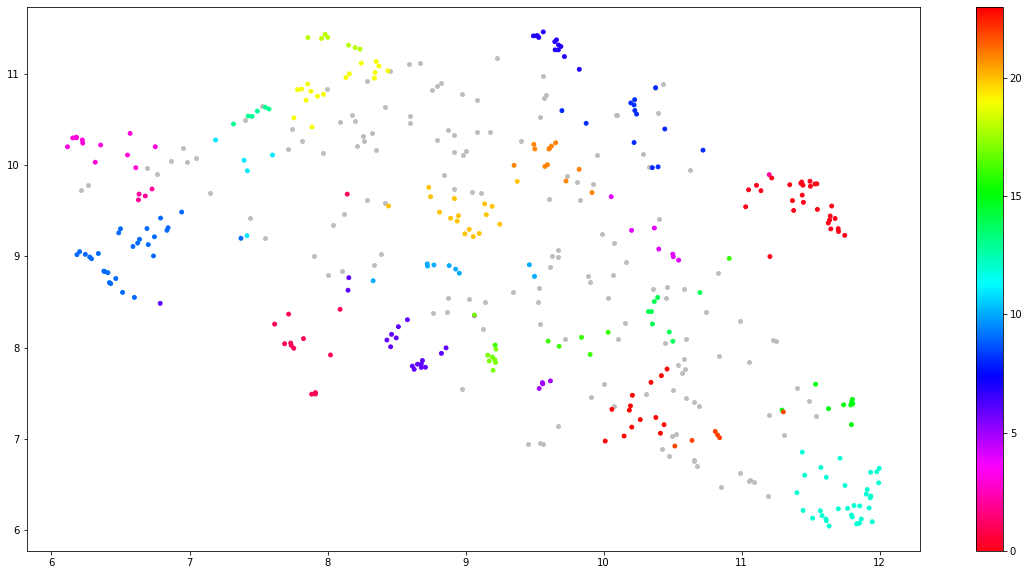

In [ ]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=20, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=15, cmap='hsv_r')
plt.colorbar()

### Top2Vec

Quelle: https://github.com/bhattbhavesh91/Top2Vec-Demo/blob/main/Top2Vec-Notebook.ipynb

In [66]:
!pip install -q numpy
!pip install -q pandas
!pip install -q gensim
!pip install -q pynndescent>=0.4
!pip install -q umap-learn
!pip install -q hdbscan
!pip install -q wordcloud
!pip install -q tensorflow
!pip install -q tensorflow_hub
!pip install -q tensorflow_text
!pip install -q torch
!pip install -q sentence_transformers
!pip install -q hnswlib
!pip install -q joblib<1.0.0
!pip install -q top2vec[sentence_transformers]

     |████████████████████████████████| 14.8MB 1.4MB/s 
ERROR: transformers 3.5.1 has requirement sentencepiece==0.1.91, but you'll have sentencepiece 0.1.96 which is incompatible.
ERROR: torchvision 0.10.0+cu102 has requirement torch==1.9.0, but you'll have torch 1.7.0 which is incompatible.
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.7.0 which is incompatible.
ERROR: sentence-transformers 2.0.0 has requirement transformers<5.0.0,>=4.6.0, but you'll have transformers 3.5.1 which is incompatible.
ERROR: flair 0.7 has requirement sentencepiece<=0.1.91, but you'll have sentencepiece 0.1.96 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: bertopic 0.8.1 has requirement numpy>=1.20.0, but you'll have numpy 1.19.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |█████████

In [67]:
import numpy as np
import pandas as pd
from copy import deepcopy
from top2vec import Top2Vec

In [68]:
docs = list(df.loc[:, "Corpus"].values)
docs[:5]

['youpuap ab1a poo sixd detection basophil activating igg autoantibody chronic idiopathic induction ann swerdt caroline van den keybus ahmad kasran phd pascal cadot phd karen neyens lieve coorevits anne marie kochuyt phd hugo degreef phd jan ceuppens phd leuven belgium background approximately patient chronic idiopathic ciu functional igg autoantibody fceria ige induce histamine release basophil cutaneous mast cell positive autologous serum skin test response believed reflect presence autoantibody objective sought define functional property develop sensitive functional assay detection autoantibody patient ciu method serum patient ciu serum healthy control subject incubated donor basophil activation basophil determined basis surface expression analyzed facscan flow cytometer result positive basophil activation test result found patient ciu basophil activating property present igg fraction serum vitro test autologous serum skin test considered basophil mast cell activating autoantibody p

In [69]:
model = Top2Vec(docs, embedding_model='universal-sentence-encoder')

2021-07-18 11:40:48,601 - top2vec - INFO - Pre-processing documents for training
2021-07-18 11:40:53,988 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 987.47MB
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
2021-07-18 11:41:15,001 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-07-18 11:41:31,331 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-07-18 11:41:36,971 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
20

In [70]:
model.get_num_topics()

1

In [71]:
topic_words, word_scores, topic_nums = model.get_topics(1)

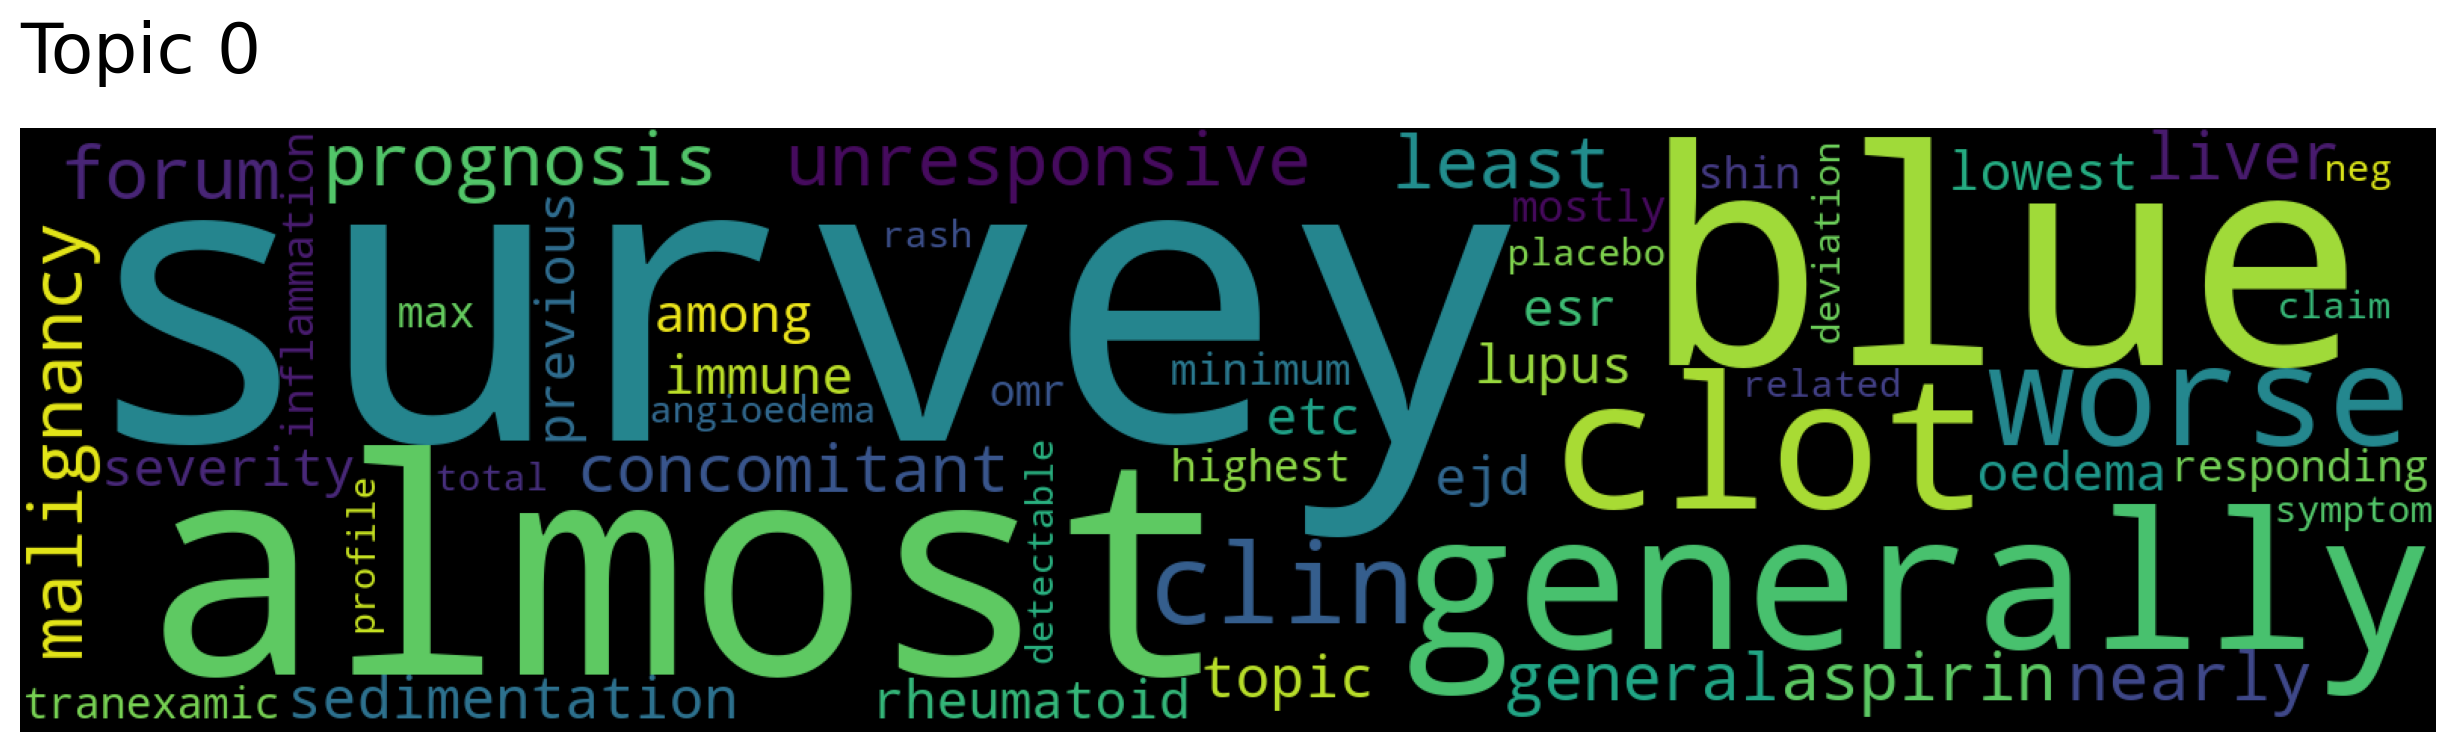

In [72]:
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

### TFIDF Vertorizer

und Extraktion der Top Wörter für jedes Paper basierend auf dem TF-IDF Score

In [46]:
tfidfconvert = TfidfVectorizer(ngram_range=(1,1)).fit(df['Corpus'].values)

In [50]:
tfidfconvert

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [47]:
len(tfidfconvert.vocabulary_)

49102

In [51]:
words_transformed = tfidfconvert.transform(df['Corpus'].values)

In [52]:
words_transformed

<454x49102 sparse matrix of type '<class 'numpy.float64'>'
	with 424030 stored elements in Compressed Sparse Row format>

In [61]:
#returns Top Word based on TFIDF-Value for each Document
df_bow = pd.DataFrame(words_transformed.toarray(),columns=tfidfconvert.get_feature_names())
df_bow.idxmax(axis=1)

0         basophil
1      cyclosporin
2            child
3          asteria
4      nonlesional
          ...     
449            ciu
450       genotype
451     omalizumab
452     omalizumab
453    mepolizumab
Length: 454, dtype: object

In [64]:
#@title Hier kann der Parameter "n" bestimmt werden. { form-width: "40%" }
n =  10 #@param {type:"integer"}

#Returns Top "n" Words based on TFIDF-Values
df_bow.apply(lambda s: s.nlargest(n).index.tolist(), axis=1)

0      [basophil, ciu, asst, patient, result, serum, ...
1      [cyclosporin, hra, week, serum, patient, place...
2      [child, admission, iqr, childhood, persistence...
3      [asteria, angioedema, oma, baseline, glacial, ...
4      [nonlesional, lesional, gene, skin, signature,...
                             ...                        
449    [ciu, bhr, jduosnueyy, serum, suppression, sou...
450    [genotype, allele, patient, polymorphism, vari...
451    [omalizumab, asteria, basophil, glacial, place...
452    [omalizumab, response, treatment, patient, uas...
453    [mepolizumab, asthma, omalizumab, patient, dov...
Length: 454, dtype: object

### K-Means Clustering

In [54]:
from sklearn.cluster import KMeans

K-Means für mehrere k's berechnen

In [55]:
Sum_of_squared_distances = []
max_range = 10
K = range(1,max_range + 1)
for k in K: 
    print(str(k) + "/" + str(max_range))
    km = KMeans(n_clusters=k)
    km = km.fit(words_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


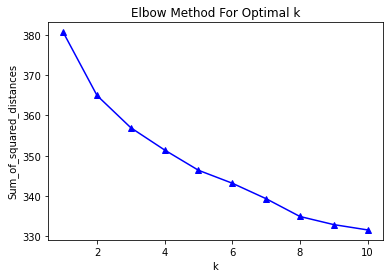

In [56]:
plt.plot(K,Sum_of_squared_distances, 'b^-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()



# **IDEEN zum Cluster bilden**


- Bag of Words kreiren um neuer Cluster / Wortgruppen zu finden über Häufigkeit der Wörter oder nähe der Wörter zu einander
- Visualisieren des Links zwischen Markern in einer HeatMap
- BioBert einsetzen
- Part of Speech recognition um Autorennamen zu identifizieren 
- AutorenNamen und Marker verknüpfen / clustern
- 


**Generelle Todo's**
- Distinct Values für Abkürzungsverzeichnis erheben und mit Markern abgleichen
- CRISP-DM als Vorgehensmoddel zugrundeliegen
- Begründen Stemm / Lemmatizing - Erörterung im Paper

# === AB HIER IRRELEVANT ===

# 1: A comprehensive overview of the markers / features

Hier vorerst Marker und Features aus der Folie. Mehr kann durch Analyse der Texte oder dem Erstellen eines Dictionaries herausgefunden werden.

In [ ]:
markers = ["Eosinopenia", "Basopenia", "IgT-anti-TPO", "CRP", "IgE"]
features = ["Activity", "Duration", "Comorbid autoimmune diseases", "Angioedema"]

def find_markers(text):
  found_markers = []
  for marker in markers:
    if marker.upper() in text.upper():
      found_markers.append(marker)
  return found_markers

def find_features(text):
  found_features = []
  for feature in features:
    if feature.upper() in text.upper():
      found_features.append(feature)
  return found_features

df['Markers'] = df['Corpus'].apply(find_markers)
df['Features'] = df['Corpus'].apply(find_features)
df

,Authors,Year,Tags,Content,Corpus,Markers,Features
0,Korosec,2009,"Basophil, Allergic Diseases, BAT, Anti-IgE",olateltar-li-lat(e (=Wien Klin Wochenschr (200...,olateltar-li-lat =wien klin wochenschr austria...,"[Basopenia, IgE]",[Angioedema]
1,Asero,2019,"D-Dimer, Duration, Total IgE, CRP, Severity",ORIGINAL ARTICLEEur ANN ALLERGY CLIN IMMUNOL V...,origin articleeur ann allergi clin immunol vol...,"[CRP, IgE]",[]
2,Asero,2020,"D-Dimer, Duration, Omalizumab, Severity",ARE CURRENTLY AVAILABLE BIOMARKERS USEFUL TO D...,are current avail biomark use discrimin csu pa...,"[Basopenia, CRP, IgE]","[Activity, Angioedema]"
3,Gentinetta,2011,"ASST, BAT, Antihistamine",Atopic dermatitis and skin diseaseIndividual I...,atop dermat skin diseaseindividu prime crucial...,[IgE],[Angioedema]
4,Deza,2017,"Severity, Omalizumab, Duration, Basophil, Alle...",Acta Dermato-VenereologicaBBFE(=)2oqo>9d3aI8A}...,acta dermato-venereologicabbf report| check up...,"[Basopenia, IgE]","[Activity, Angioedema]"
...,...,...,...,...,...,...,...
449,Wardhana,2012,"anti-FcεRI, Antihistamine",SPECIAL ARTICLE Chronic Autoimmune UrticariaW...,special articl chronic autoimmun urticariaward...,[IgE],"[Activity, Angioedema]"
450,Kocatürk,2017,"Antihistamine, Omalizumab",Journal of Dermatological Science 87 (2017) 60...,journal dermatolog scienc naselsevi journal de...,[],[Angioedema]
451,Atwa,2014,"ASST, serverity",DOI: 10.1114 1/dv.12124ORIGINAL ARTICLESerum c...,doi articleserum concentr tnf- amongpati chron...,[IgE],[]
452,Kocatürk,2019,"Severity, Duration",World Allergy Organization Journal 12 (2019) 1...,world allergi organ journal content list avail...,[],"[Activity, Angioedema]"


# 2: To understand how the markers/features of Type IIb aiCSU are linked


## How strong is the link between any two given markers? ​

Erste Definition Julian:
 $$link=\frac{AB}{\frac{A+B}{2}}$$


In [ ]:
def str_contains(text, a, b):
  if a in text:
    if b in text:
      return True
  return False

def get_link(a, b):
  if a == b:
    return 1
  # count_a = df[df.Markers.str.join(',').str.contains(a)].Markers.count()
  # count_b = df[df.Markers.str.join(',').str.contains(b)].Markers.count()
  # count_ab = df[df.Markers.str.join(',').str.contains(b)].Markers.count()
  count_a = df[df.Markers.apply(str_contains, a=a, b=a)].Markers.count()
  count_b = df[df.Markers.apply(str_contains, a=b, b=b)].Markers.count()
  count_ab = df[df.Markers.apply(str_contains, a=a, b=b)].Markers.count()
  return (count_ab/(0.5*(count_a+count_b)))


link = get_link(markers[0], markers[1])
link
# df_x = df[df['Markers'].isin(['IgE'])]
# df_x
# df_x = df[all(x in  for x in [])]['Markers'].count()
# df_x = df.Markers.to_list()
# all(x in ['b', 'a', 'foo', 'bar'] for x in ['a', 'b'])

# all(x in ['b', 'a', 'foo', 'bar'] for x in ['a', 'b'])
# df_x


# df[str_contains(df.Markers.str.join(','), , )]

# df['Markers'].apply(str_contains, a = 'CRP', b='IgE')

0.25925925925925924

In [ ]:
# df_markers = pd.DataFrame()
# for marker_a in markers:
#   df_markers[marker_a] = []
#   #marker_links = []
#   for marker_b in markers:
#     df_markers = df_markers[marker_a].append(pd.Series(get_link(marker_a, marker_b)))
#   #df_markers.append(marker_links)
# df_markers

# mylist = []
# for marker in markers:
#   mylist.append(markers)

# mylist

# df_markers = pd.DataFrame(markers, columns=markers)
# df_markers


df_markers = pd.DataFrame(index=markers, columns=markers)
df_markers

for marker_a in markers:
  for marker_b in markers:
    df_markers[marker_a][marker_b] = get_link(marker_a, marker_b)

df_markers

,Eosinopenia,Basopenia,IgT-anti-TPO,CRP,IgE
Eosinopenia,1,0.259259,0,0.0555556,0.039801
Basopenia,0.259259,1,0,0.219178,0.209091
IgT-anti-TPO,0,0,1,0,0
CRP,0.0555556,0.219178,0,1,0.34413
IgE,0.039801,0.209091,0,0.34413,1


## Did the publication show a difference for marker a in patients stratified by marker b (and vice versa) and how big was the difference? ​

## Did the publication show a correlation between a and b and how strong was it? ​

## Was the result of a study that showed a link between a and b reproducible? ​


## How many studies confirmed the link? 

## How many studies failed to reproduce the link? ​

## How good is the quality of the study that demonstrates a link (how many patients?, how well characterized?, multicenter?, prospective vs retrospective, etc….)?